* load lightning module from checkpoints
* eval models with various decision score on metrics
* visualisation sample

In [1]:
import hydra
from src.commons.constants import PROJECT_PATH
from omegaconf import DictConfig, OmegaConf

import numpy as np
import cv2
from PIL import Image
import torch
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from torch.utils import data
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

from src.commons.utils_io import load_sam, make_path, check_dir
from src.commons.utils import *
from src.models.commons.mask_process import extract_object_from_batch, binarize_mask
from src.commons.constants import *
from src.data.process import generate_grid_prompt
from src.models.magic_pen.task import MagicPenModule

### Load config from run

Inside a Lightning checkpoint you’ll find:

* 16-bit scaling factor (if using 16-bit precision training)
* Current epoch
* Global step
* LightningModule’s state_dict
* State of all optimizers
* State of all learning rate schedulers
* State of all callbacks (for stateful callbacks)
* State of datamodule (for stateful datamodules)
* The hyperparameters (init arguments) with which the model was created
* The hyperparameters (init arguments) with which the datamodule was created 
* State of Loops

In [2]:
_SHARE_PATH = "levir-cd/vit-b"

def _cfg_meta(exp_name, id_exp, folder_root=None, description=""):
    """generate register items - to be updated"""
    if folder_root is None: folder_root = ""
    cfg = {
        "path": make_path(
                    id_exp, 
                    LOGS_PATH, 
                    folder_root,
                    exp_name,
                    _SHARE_PATH
                ),
        "description": description
    }

    if not os.path.exists(cfg["path"]): 
        raise FileNotFoundError(f"Exp run logs not found :{cfg['path']}")
    return cfg

# TODO: integrate in src/
_register_runs = {
    "probing_concat_baseline": 
        _cfg_meta("train_probing_concat", "2024-08-07_17-50-07", folder_root="08082024_train_first_modules", description=""),
    "probing_diff_baseline":
        _cfg_meta("train_probing_diff", "2024-08-07_17-50-30", folder_root="08082024_train_first_modules", description=""),
    "probing_attn_baseline":
        _cfg_meta("train_probing_attn", "2024-08-07_17-51-53", folder_root="08082024_train_first_modules", description=""),
    "adapter_diff":
        _cfg_meta("train_adapter_diff", "2024-08-07_17-52-31", folder_root="08082024_train_first_modules", description=""),
    "adapter_concat":
        _cfg_meta("train_adapter_concat", "2024-08-07_17-53-32", folder_root="08082024_train_first_modules", description=""),
    "adapter_attn":
        _cfg_meta("train_adapter_attn", "2024-08-07_18-15-08", folder_root="08082024_train_first_modules", description=""),
    "lora_diff":
        _cfg_meta("train_lora_diff", "2024-08-07_18-22-22", folder_root="08082024_train_first_modules", description=""),
    "lora_concat":
        _cfg_meta("train_lora_concat", "2024-08-07_18-21-49", folder_root="08082024_train_first_modules", description=""),
    "lora_attn":
        _cfg_meta("train_lora_attn", "2024-08-07_18-22-20", folder_root="08082024_train_first_modules", description=""),
}

def find_best_ckpt(run_path):
    run_path = os.path.join(run_path, "checkpoints")
    fname = [_ for _ in os.listdir(run_path) if _.startswith("epoch_")]
    if fname:
        fname=fname[0]
    else:
        raise ValueError("ckpt not found")
    return make_path(fname, run_path)

def check_exp(exp_name):
    if exp_name not in _register_runs:
        raise(f"Exp name {exp_name} not found")

def _cfg_path(exp_name):
    check_exp(exp_name)
    return make_path(
        ".hydra/config.yaml",
        _register_runs[exp_name]["path"],
        )

def _ckpt_path(exp_name):
    check_exp(exp_name)
    return find_best_ckpt(_register_runs[exp_name]["path"])

def load_default_loss():
    return nn.BCEWithLogitsLoss()

In [3]:
#model.optimzier.load_state_dict(MyMode.load_optimizer_checkpoint(last_checkpoint))

In [4]:
def load_cfg(exp_name):
    return OmegaConf.load(_cfg_path(exp_name))


def load_params_module(cfg):
    scheduler, optimizer = None, None
    loss = load_default_loss()
    model = hydra.utils.instantiate(cfg.model.instance.network)
    if "optimizer" in cfg.model:
        optimizer = hydra.utils.instantiate(cfg.model.optimizer)
    if "scheduler" in cfg.model:
        scheduler = hydra.utils.instantiate(cfg.model.scheduler)
    if "loss" in cfg.model:
        loss = hydra.utils.instantiate(cfg.model.loss)
        
    return dict(model=model, optimizer=optimizer, scheduler=scheduler, loss=loss, task_name=cfg.task_name)

def load_dmodule(cfg):
    return hydra.utils.instantiate(cfg.data)

def load_lmodule(exp_name, params):
    return MagicPenModule.load_from_checkpoint(
        _ckpt_path(exp_name),
        optimizer=params.get("optimizer"),
        scheduler=params.get("scheduler"),
        loss=params.get("loss"),
        network = params.get("model"),
        task_name=params.get("task_name")
    )

def load_exp(exp_name):
    
    cfg = load_cfg(exp_name)
    params = load_params_module(cfg)
    data_module = load_dmodule(cfg)
    module = load_lmodule(exp_name, params)
    
    return cfg, data_module, module

In [5]:
exp_name = "probing_concat_baseline"
cfg, data_module, module = load_exp(exp_name)

INIT VIT


2024-08-12 15:59:16,821 - INFO ::  Weights loaded for : ['image_encoder']


#### Restoring Training State
If you don’t just want to load weights, but instead restore the full training, do the following:
```
model = LitModel()
trainer = Trainer(resume_from_checkpoint='some/path/to/my_checkpoint.ckpt')

# automatically restores model, epoch, step, LR schedulers, apex, etc...
trainer.fit(model)
```

### Run inference

In [6]:
def get_dloader(mode: str, dmodule):

    def wrap_mode(mode):
        if mode == "train":
            return "fit"
        return mode
    if not dmodule.ds_dict_type:
        mode_ = wrap_mode(mode)
        dmodule.setup(mode_)
    factory_dl = {
        "train": dmodule.train_dataloader,
        "val": dmodule.val_dataloader,
        "test": dmodule.test_dataloader,
    }
    return factory_dl[mode]()

def get_ds(mode: str, dmodule):
    
    def wrap_mode(mode):
        if mode == "train":
            return "fit"
        return mode
        
    if not dmodule.ds_dict_type:
        mode_ = wrap_mode(mode)
        dmodule.setup(mode_)
        
    return dmodule.ds_dict_type[mode]

In [7]:
dloader = get_dloader("test", data_module)
ds = get_ds("test", data_module)

In [8]:
batch = next(iter(dloader))

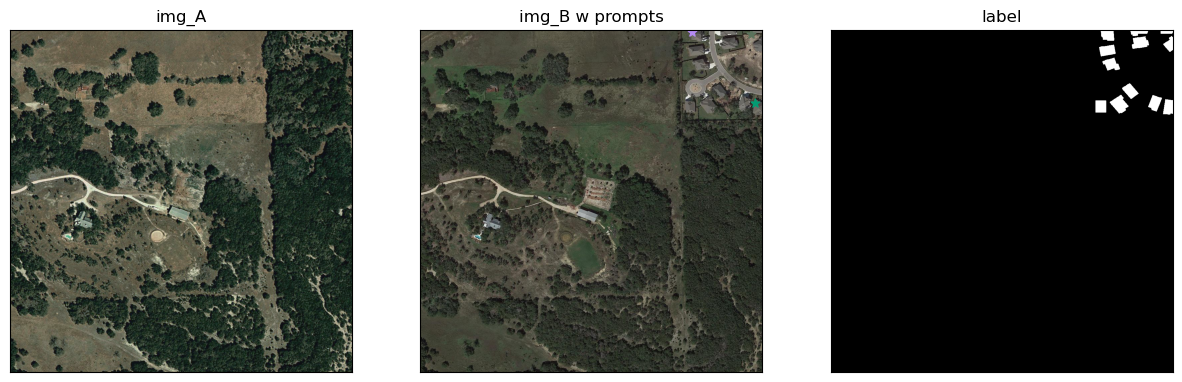

In [9]:
show_sample_from_batch(batch, idx=0)

In [10]:
def infer_on_sample(ds, module, fname=None, fidx=None):
    if not any([fname, fidx]):
        raise ValueError("Please provide at least a sample name or an sample index")
    # priority to fname
    if fname is not None:
        fidx = ds.get_from_name(fname, return_sample=False)
    # TODO: allow indices sequence
    if isinstance(fidx, int): fidx = [fidx]
    sub_dl = data.DataLoader(data.Subset(ds, fidx), batch_size=1, shuffle=False)
    batch = next(iter(sub_dl))

    # workaround  prevent wrong device association buffers in SAM
    # module = module.to("cpu")
    preds, _ = module(batch)
    # B x 1 x 1024 x 1024
    preds = preds.squeeze().detach().cpu()
    label = label.squeeze().detach().cpu()
    return preds, label, batch

In [11]:
def convert_to_device(batch, device="cuda"):
    for name in ['img_A', 'img_B', 'label', 'point_coords', 'point_labels']:
        batch[name] = batch[name].to(device)
    return batch

### Eval on instances

In [12]:
PROJECT_PATH

'/home/MDizier/projects/stage_stylo_magique_2024'

In [13]:
ls /home/MDizier/projects/stage_stylo_magique_2024

configs/            environment.yml  logs@       reports/  src/
data/               LICENSE          notebooks/  scripts/  tests/
environment_jz.yml  lightning_logs@  README.md   setup.py  tmp/


In [51]:
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryF1Score, BinaryJaccardIndex, BinaryRecall, BinaryPrecision

exp_name = "lora_concat"
ds_name = "levir-cd"
device = "cuda"
batch_size = 1
ds_type = "test"


metric_list = [
    BinaryF1Score,
    BinaryJaccardIndex,
    BinaryRecall,
    BinaryPrecision,
]

report_dir = check_dir(PROJECT_PATH, "reports", "scores", ds_name, "instances", exp_name)

labels_track = []
df_all_th = []
th_list = np.arange(0., 1, 0.1)
scores = dict(zip(th_list, [[] for _ in range(len(th_list))]))

cfg, data_module, module = load_exp(exp_name)
ds = get_ds(ds_type, data_module)
dloader = data.DataLoader(ds, batch_size=batch_size, shuffle=False)

module = module.to(device)
sgmd = nn.Sigmoid()

@torch.no_grad()
def _step(module, batch, device):
    
    batch = convert_to_device(batch, device=device)
    preds, _ = module(batch)
    preds = preds.squeeze().detach()
    preds = sgmd(preds)
    label = batch["label"].squeeze().detach()
    return preds, label
    
for i, batch in enumerate(tqdm(dloader)):
    
    preds, label = _step(module, batch, device)
    
    for th in th_list:
        eval_engine = MetricCollection([m(threshold=th).to(device) for m in metric_list])
        scores[th].append(eval_engine(preds, label))
    
    labels_track.append(next(iter(batch["label_path"])))

for th, res in scores.items():
    df_score = pd.DataFrame(res).map(float)
    df_score = df_score.assign(
        label_path=labels_track,
        th=th
    )
    df_all_th.append(df_score)
df_all_th = pd.concat(df_all_th)
df_all_th.to_csv(make_path(f"{exp_name}.csv", report_dir), index=True)

INIT VIT
INIT LORA VIT


2024-08-12 16:42:33,592 - INFO ::  Weights loaded for : ['image_encoder']
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:04<00:00,  1.91s/it]


In [52]:
df = pd.read_csv(make_path(f"{exp_name}.csv", report_dir), index_col=0)

In [53]:
metrics_col = [_ for _ in df.columns if _ not in ["label_path", "th"]] 
scores = df.groupby("th")[metrics_col].mean()

Text(0.5, 1.0, 'Scores based decision threshold - lora_concat - test set')

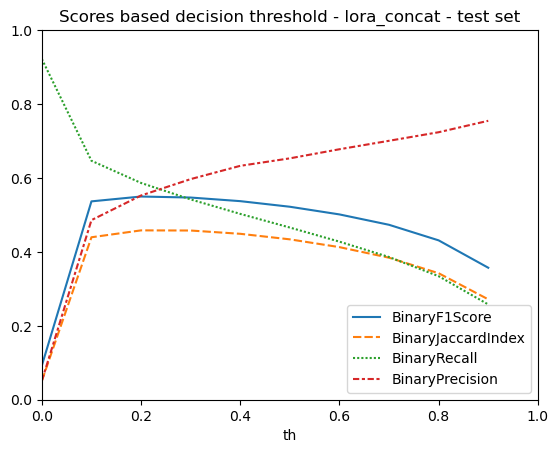

In [54]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

Text(0.5, 1.0, 'Scores based decision threshold - adapter_concat - test set')

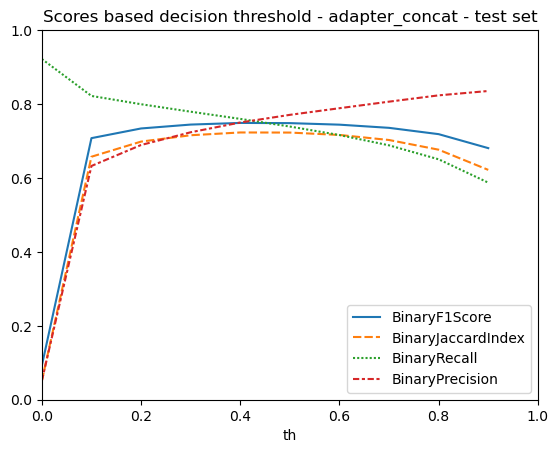

In [50]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

Text(0.5, 1.0, 'Scores based decision threshold - probing_concat_baseline')

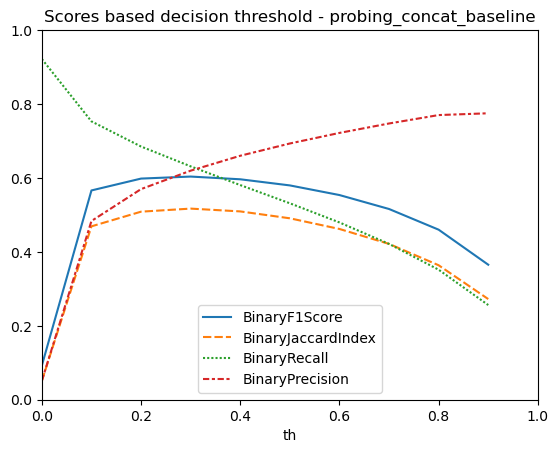

In [38]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

In [35]:
scores

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.092513,0.050943,0.921875,0.050943
0.1,0.566229,0.469083,0.753108,0.483547
0.2,0.598322,0.508797,0.685064,0.569864
0.3,0.603792,0.517091,0.631404,0.619719
0.4,0.596410,0.509497,0.580730,0.660067
0.5,0.579846,0.490847,0.531492,0.693277
0.6,0.553774,0.461988,0.479626,0.721880
0.7,0.516029,0.421604,0.421558,0.747399
0.8,0.460049,0.363825,0.351758,0.770179


## Annexes

### Influence des values null : missing labels ?

In [46]:
df[(df.BinaryJaccardIndex > 0) & (~df.BinaryJaccardIndex.isna())].groupby("th")[metrics_col].mean()

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.100353,0.055260,1.000000,0.055260
0.1,0.624804,0.477171,0.831016,0.533569
0.2,0.665959,0.522070,0.762506,0.634284
0.3,0.677942,0.535234,0.708945,0.695825
0.4,0.675580,0.532041,0.657818,0.747687
0.5,0.662681,0.517143,0.607419,0.792317
0.6,0.632884,0.486738,0.548144,0.825006
0.7,0.595061,0.448192,0.486121,0.861865
0.8,0.535330,0.390285,0.409318,0.896209


+0.1 en enlevant les nan et 0 :o

<Axes: >

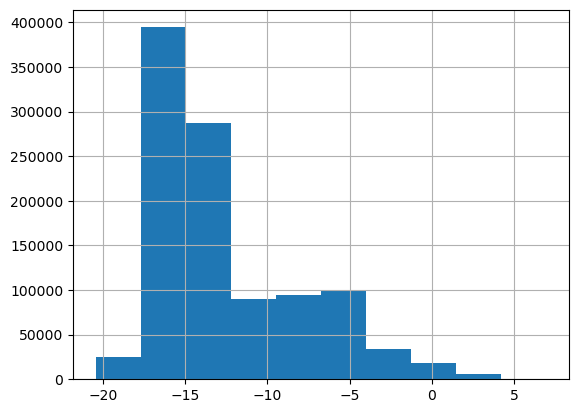

In [48]:
pd.Series(preds.flatten()).hist()

<Axes: >

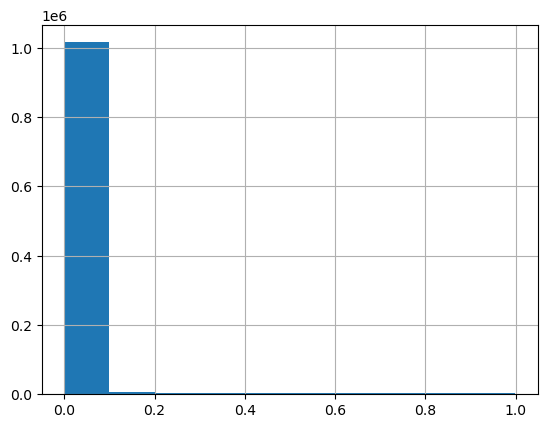

In [49]:
pd.Series(nn.Sigmoid()(preds.flatten())).hist()

<Axes: >

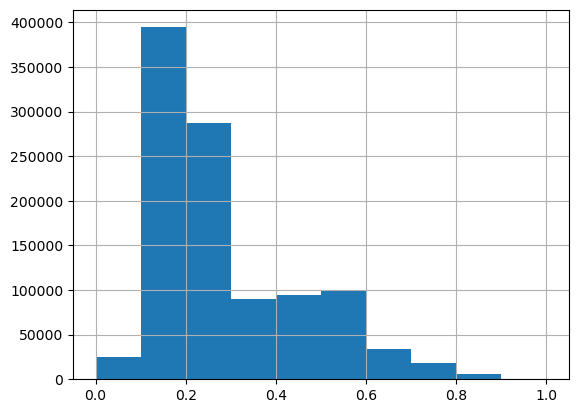

In [50]:
pd.Series(shift_range_values(preds.flatten())).hist()